In [23]:
import os
import re
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import joblib
from pathlib import Path


In [24]:
DATA_PATH = Path("../data/processed/cityx_clean.parquet")

In [25]:
DATA = pd.read_parquet(DATA_PATH)

In [26]:
print(DATA.columns)

Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'Latitude (Y)', 'Longitude (X)', 'Hour',
       'Month', 'Year', 'DayOfWeek_num', 'DayOfMonth', 'WeekOfYear',
       'TimeOfDay', 'Season', 'AddressType'],
      dtype='object')


In [27]:
# Train/test split + class weights
X = DATA["Descript"].values
y = DATA["Category"].values

# Stratify is very important to maintain the same distribution of classes in training and testing as in the original data (especially when classes are unbalanced).

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Compute class weights for imbalanced data
classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = dict(zip(classes, weights))


In [28]:
# Text classification pipeline (TF-IDF + LinearSVC)

# Build text classification pipeline
clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=500,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.9,
        stop_words="english"
    )),
    ("svm", LinearSVC(class_weight=class_weight, random_state=42))
])

# Train model
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [29]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
# =====1. Create a full classification report =====
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).transpose()

# Save report to CSV file 
report_df.to_csv("classification_report.csv", index=True)

# Show first 10 rows as an example
print("\n=== Classification Report (Top 10) ===")
print(report_df.head(10))




=== Classification Report (Top 10) ===
                        precision    recall  f1-score  support
ARSON                    1.000000  0.974729  0.987203    277.0
BAD CHECKS               1.000000  1.000000  1.000000     73.0
BRIBERY                  0.961538  0.480769  0.641026     52.0
BURGLARY                 1.000000  1.000000  1.000000   6581.0
DISORDERLY CONDUCT       1.000000  1.000000  1.000000    778.0
DRUG/NARCOTIC            0.998163  0.995629  0.996894   7093.0
EMBEZZLEMENT             0.686667  1.000000  0.814229    206.0
EXTORTION                0.074135  1.000000  0.138037     45.0
FORGERY/COUNTERFEITING   1.000000  0.992593  0.996283   1755.0
FRAUD                    0.991599  0.985638  0.988610   2994.0


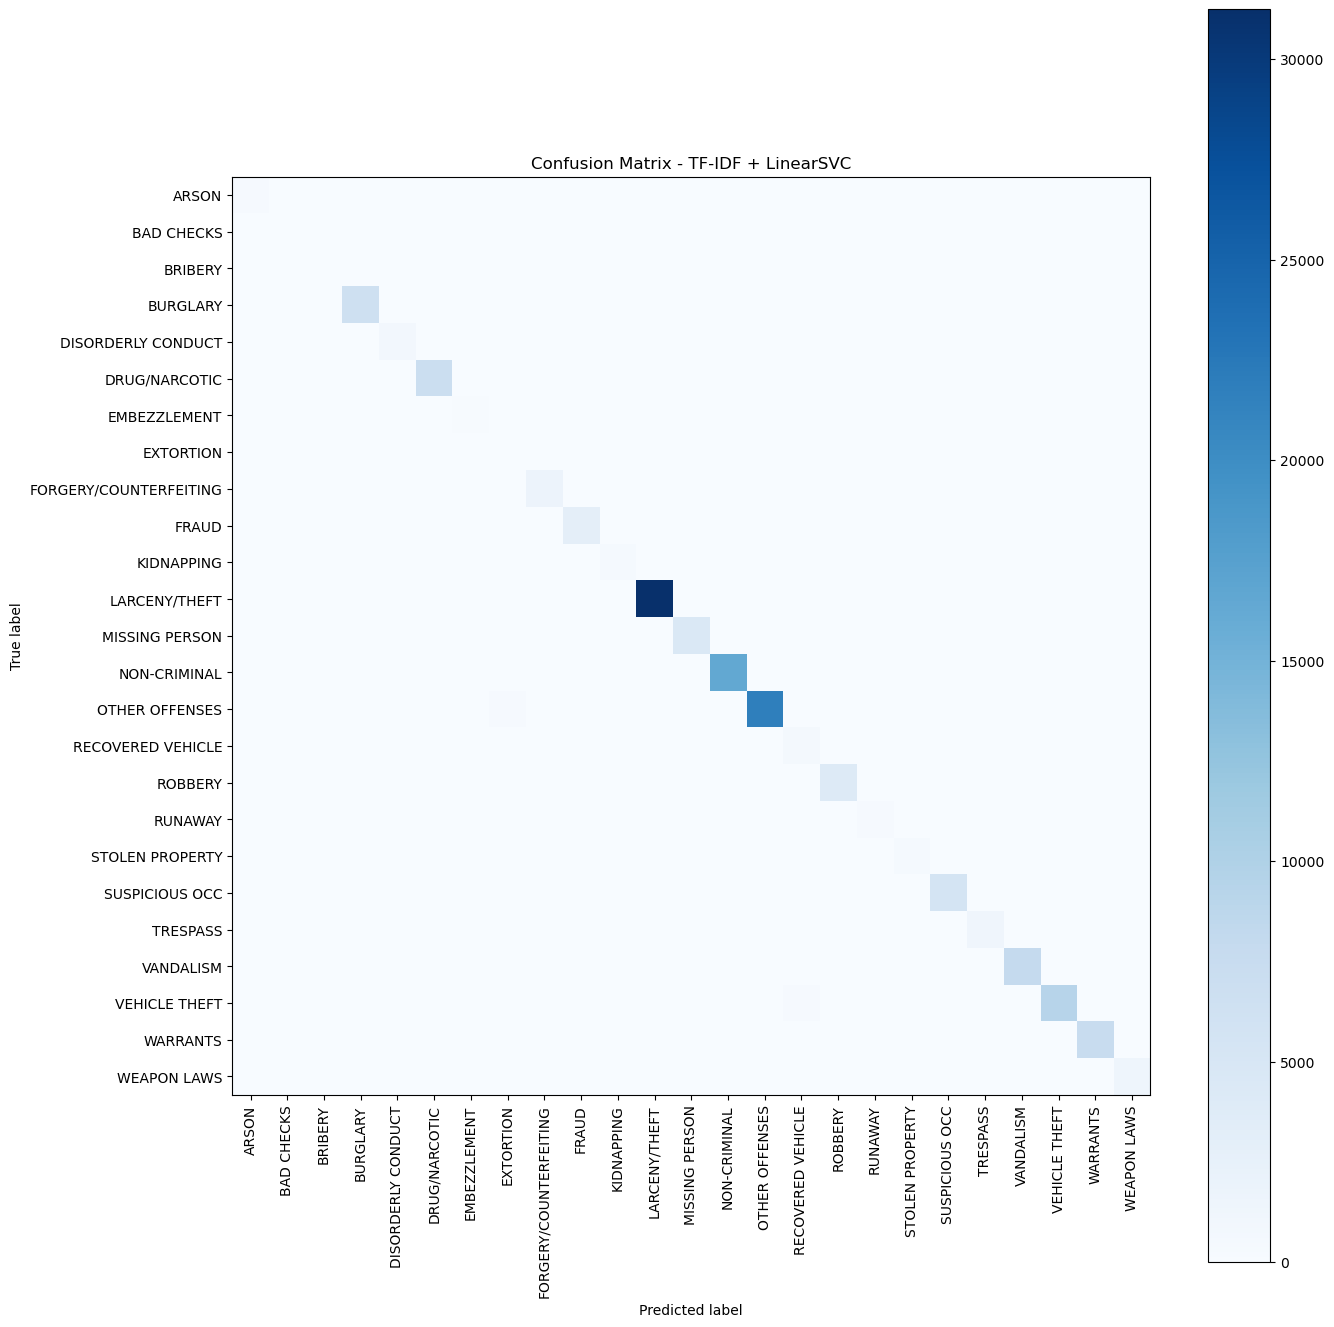


=== Overall Metrics ===
Accuracy     : 0.9916
Macro-F1     : 0.9308
Weighted-F1  : 0.9936


In [30]:
# =====Ceate a confusion matrix =====
labels_sorted = sorted(np.unique(y_test))
cm = confusion_matrix(y_test, y_pred, labels=labels_sorted)

# Display it in a beautiful visual form.
# xticks_rotation=90 → Rotates class names on the X-axis by 90° to prevent overlap.
plt.figure(figsize=(14, 14))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_sorted)
disp.plot(include_values=False, cmap='Blues', ax=plt.gca(), xticks_rotation=90)
plt.title("Confusion Matrix - TF-IDF + LinearSVC")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

# ===== Show General Metrics =====
macro_f1 = report_dict["macro avg"]["f1-score"]
weighted_f1 = report_dict["weighted avg"]["f1-score"]
accuracy = report_dict["accuracy"]

print("\n=== Overall Metrics ===")
print(f"Accuracy     : {accuracy:.4f}")
print(f"Macro-F1     : {macro_f1:.4f}")
print(f"Weighted-F1  : {weighted_f1:.4f}")

In [31]:
# Assigning Crime Serverity

In [32]:
SEVERITY_MAP = {
    1: {"NON-CRIMINAL", "SUSPICIOUS OCCURRENCE", "MISSING PERSON", "RUNAWAY", "RECOVERED VEHICLE"},
    2: {"WARRANTS", "OTHER OFFENSES", "VANDALISM", "TRESPASS", "DISORDERLY CONDUCT", "BAD CHECKS"},
    3: {"LARCENY/THEFT", "VEHICLE THEFT", "FORGERY/COUNTERFEITING", "DRUG/NARCOTIC",
        "STOLEN PROPERTY", "FRAUD", "BRIBERY", "EMBEZZLEMENT"},
    4: {"ROBBERY", "WEAPON LAWS", "BURGLARY", "EXTORTION"},
    5: {"KIDNAPPING", "ARSON"},
}

# Build reverse lookup for O(1) assignment
CATEGORY_TO_SEVERITY = {}
for sev, cats in SEVERITY_MAP.items():
    for c in cats:
        CATEGORY_TO_SEVERITY[c.upper()] = sev

def assign_severity(category: str, default=None):
    if not isinstance(category, str):
        return default
    return CATEGORY_TO_SEVERITY.get(category.upper(), default)

In [36]:
# Save the trained pipeline
os.makedirs("/mnt/data", exist_ok=True)
joblib.dump({"pipeline": clf, "classes": clf.named_steps["svm"].classes_},
            "../models/crime_category_text_model.pkl")

# Predict for all rows that have Descript
DATA["PredictedCategory"] = np.nan
mask = DATA["Descript"].str.len() > 0
DATA.loc[mask, "PredictedCategory"] = clf.predict(DATA.loc[mask, "Descript"])

# Assign severity (from ground-truth Category if present, else from predicted)
DATA["Severity_From_True"] = DATA["Category"].apply(assign_severity)
DATA["Severity_From_Pred"] = DATA["PredictedCategory"].apply(assign_severity)

# Export predictions
out_csv = "/mnt/data/cityx_level2_predictions.csv"
DATA.to_csv(out_csv, index=False)
print("Saved predictions to:", out_csv)
print("Saved model to:../models/crime_category_text_model.pkl")


C:\Users\HP\AppData\Local\Temp\ipykernel_11000\538938015.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['WARRANTS' 'OTHER OFFENSES' 'OTHER OFFENSES' ... 'LARCENY/THEFT'
 'VANDALISM' 'FORGERY/COUNTERFEITING']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  DATA.loc[mask, "PredictedCategory"] = clf.predict(DATA.loc[mask, "Descript"])


Saved predictions to: /mnt/data/cityx_level2_predictions.csv
Saved model to:../models/crime_category_text_model.pkl


In [37]:
def predict_category_and_severity(texts):
    pack = joblib.load("/mnt/data/crime_category_text_model.pkl")
    pipe = pack["pipeline"]
    #texts_clean = [clean_text(t) for t in texts]
    cats = pipe.predict(texts)
    sevs = [assign_severity(c) for c in cats]
    return list(zip(texts, cats, sevs))

# Example:
predict_category_and_severity([
    "Suspect broke into parked vehicle and stole laptop.",
    "Arson investigation initiated after reports of fire in warehouse."
])


[('Suspect broke into parked vehicle and stole laptop.', 'EMBEZZLEMENT', 3),
 ('Arson investigation initiated after reports of fire in warehouse.',
  'ARSON',
  5)]